## **Advertising Dataset Preparation**

- **Source:** Meta API
This dataset appears to contain information related to advertising campaigns on a digital platform, likely social media.

- **Dataset Shape:** 629 rows 10 columns
- The dataset is prepared using Mistral 8*7B for the columns "Goal"
- Steps include setting the prompt and converting the dataset to Mistral model input format

- The Dataset is Scalable

- The dataset can be used for Copywriting Agent


### Dataset Preparation for advertising

In [ ]:
!pip install pandas numpy matplotlib seaborn swifter missingno logzero nltk tensorflow transformers keras torch gensim
!pip install --upgrade duckduckgo_search
!pip install --upgrade langchain
!pip install langchain-groq #langchain module
!pip install wikipedia
!pip install python-dotenv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import missingno as mno
sns.set_style("darkgrid", {"grid.color": ".2", "grid.linestyle": ":"})
from groq import Groq
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from google.colab import userdata
import pandas as pd
import numpy as np
import warnings
# Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from google.colab import userdata
import pandas as pd
import ast
from langchain.agents import Tool
GROQ_API_KEY3=userdata.get('GROQ_API_KEY')

GROQ_API_KEY=userdata.get('GROQ_API_KEY')
client = Groq(api_key=GROQ_API_KEY,)

In [ ]:
ads_insight_df = pd.read_csv("/content/all_ads_data.csv")
campaigns_df = pd.read_csv("/content/all_ad_creatives_with_insights.csv")

In [ ]:
def extract_adset_name(adset_str):
    match = re.search(r'"name": "([^"]+)"', adset_str)
    return match.group(1) if match else None

def extract_adcreative_body(adcreatives_str):
   try:
       adcreatives_dict = ast.literal_eval(adcreatives_str)
       body = adcreatives_dict.get('data', [{}])[0].get('body')
       return body

   except (ValueError, SyntaxError, IndexError):
       return None

def extract_campaign_id(campaign_str):
    match = re.search(r'"id": "([^"]+)"', campaign_str)
    return match.group(1) if match else None

def extract_adcreative_image(adcreatives_str):
    try:
        adcreatives_dict = ast.literal_eval(adcreatives_str)
        data_list = adcreatives_dict.get('data', [])
        if data_list:
            image_url = data_list[0].get('image_url', '') or data_list[0].get('thumbnail_url', '')
            return image_url

    except (ValueError, SyntaxError, IndexError):
        pass

    return

In [ ]:
# Apply the functions to create new columns
ads_insight_df['adset_name'] = ads_insight_df['adset'].swifter.apply(extract_adset_name)
ads_insight_df["campaign_id"] = ads_insight_df["campaign"].swifter.apply(extract_campaign_id)
ads_insight_df['adcreatives_body'] = ads_insight_df['adcreatives'].swifter.apply(extract_adcreative_body)
ads_insight_df["image_url"] = ads_insight_df["adcreatives"].swifter.apply(extract_adcreative_image)

In [ ]:
ads_insight_df.head()

In [ ]:
# Count of non-null values
not_null_count = ads_insight_df["image_url"].notna().sum()
print("Not null values for Image section:", not_null_count)

# Count of null values
null_count = ads_insight_df["image_url"].isna().sum()
print("Null values for Image section:", null_count)

In [ ]:
#Download the images now
import requests
from urllib.parse import urlparse
import os
# import time

def is_valid_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False


default_extension = '.jpg'
def download_images(image_urls, download_folder):
    image_paths = []
    for image_url in image_urls:
        if is_valid_url(image_url):
            response = requests.get(image_url)

            # Extract filename from URL
            parsed_url = urlparse(image_url)
            image_name = os.path.basename(parsed_url.path)

            # Remove invalid characters from filename
            image_name = ''.join(c if c.isalnum() or c in ['.', '_'] else '_' for c in image_name)

            # Split the filename into base name and extension
            base_name, extension = os.path.splitext(image_name)

            # If no extension or extension is invalid, use default_extension
            if not extension or extension.lower() not in ['.jpg', '.jpeg', '.png', '.gif']:
                extension = default_extension

            image_path = os.path.join(os.getcwd(), download_folder, f"{base_name}{extension}")

            with open(image_path, 'wb') as f:
                f.write(response.content)
                # time.sleep(2)

            image_paths.append(image_path)
        else:
            image_paths.append(None)

    return image_paths

In [ ]:
# Create a folder for downloaded images
download_folder = 'downloaded_images'
os.makedirs(download_folder, exist_ok=True)

image_urls = ads_insight_df['image_url'].dropna().apply(lambda x: x.strip())

# Download images
valid_image_urls = image_urls[image_urls.apply(is_valid_url)].reset_index(drop=True)

image_paths_series = pd.Series(download_images(valid_image_urls, download_folder), index=valid_image_urls.index)

ads_insight_df["image_path"] = image_paths_series

In [ ]:
ads_insight_df.shape

In [ ]:
ads_insight_df.head(10)

In [ ]:
ads_insight_df.to_csv('/content/data.csv')

In [ ]:
first_column = ads_insight_df.iloc[:, 0]
print(first_column.head())

### Transform dataset

In [ ]:
import pandas as pd
df=pd.read_csv('/content/data.csv')

# Extract the 'adcreatives_body' column
adcreatives_body_column = df['adcreatives_body']

# Create a new DataFrame with only the 'adcreatives_body' column
df = pd.DataFrame(adcreatives_body_column)

# Save the extracted column to a new CSV file
df.to_csv('/content/adcreatives_body_column.csv', index=False)

print("adcreatives_body column saved to 'adcreatives_body_column.csv'")
df.head()

### Langchain dataset

In [ ]:

client = Groq(
    api_key=GROQ_API_KEY3,
)

In [ ]:
def get_llm_output(prompt):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="mixtral-8x7b-32768",
    )
    return (chat_completion.choices[0].message.content)


def set_prompt_option(description, categories):
    # Define prompt
    prompt_template = f"""Pick values from the given the list of categories:  "{categories}"
    that relate to the text: "{description}"
    Choose values from the list that matches the Post description:"{categories}" . reduce the output size in maximum 2 words. return nothing if not found.
    CATEGORIES OUTPUT LIST:"""
    return prompt_template


def find_words_in_sentence(sentence, word_list):
    words_found = []
    for word in word_list:
        if word.lower() in sentence.lower():
            words_found.append(word)
    print("Words found in the sentence:", words_found)
    return words_found

In [ ]:
categories = ['Ideal customer', 'Returning From Holidays', 'Offsite', 'The Newlyweds', 'The Anniversaries', 'The Vegan', 'The Vegetarian', 'I Single', 'The Graduating Student', 'The Saver', 'The couples', 'Commuters', 'The tourist']
final_df = pd.DataFrame(columns=["description", "category"])

# Iterate over each post in the 'adcreatives_body' column
for i in range(df.shape[0]):
    print("*****************************", i)
    if pd.isna(df["adcreatives_body"].iloc[i]):
        continue

    new_d = {}
    post = df["adcreatives_body"].iloc[i]
    prompt = set_prompt_option(post, categories)
    description = get_llm_output(prompt)
    category_list = find_words_in_sentence(description, categories)

    new_d["description"] = post
    new_d["category"] = category_list

    df_temp = pd.DataFrame([new_d])

    # Append the new row to the final_df
    final_df = pd.concat([final_df, df_temp], ignore_index=True)
    if i%50 == 0:
      final_df.to_csv("/content/drive/MyDrive/Jyoti_WorkSpace/dataset_prep_final.csv", index = False)

print(final_df)

In [ ]:
final_df.head(10)

### Transform dataset

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

final_df=pd.read_csv('/content/advertisingDataset (1).csv')
final_df

,description,category
0,Celebrare i momenti speciali in luoghi altrett...,"['The Newlyweds', 'The Anniversaries']"
1,🎉✨ Benvenuti nel nostro esclusivo Cenone di Ca...,"['Ideal customer', 'The tourist']"
2,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,['The Vegetarian']
3,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,['The Vegetarian']
4,"🎄 Festeggia il Natale con Gusto, il nostro Men...","['The Vegan', 'The Vegetarian', 'The Saver']"
...,...,...
471,🌺Leggi quello che i nostri clienti dicono di n...,"['Commuters', 'The tourist']"
472,test copy,"['Ideal customer', 'The Vegetarian']"
473,💙Scopri cosa dicono di noi!💞 \n🌐Dai un'occhiat...,['Commuters']
474,😎Scopri cosa i nostri clienti scrivono di noi....,['Commuters']


In [ ]:
final_df.shape

(476, 3)

In [ ]:
ss =  "['The Newlyweds', 'The Anniversaries']"
print(type(ss), ss.replace('[', '').replace(']', '').replace("'", ''))

In [ ]:
# Remove the special characters '[' ']' "'"
for i in range(final_df.shape[0]):
  cat = final_df["category"].iloc[i]
  cat = cat.replace('[', '').replace(']', '').replace("'", '')
  final_df["category"].iloc[i] = cat
final_df.head()

,description,category
0,Celebrare i momenti speciali in luoghi altrett...,"The Newlyweds, The Anniversaries"
1,🎉✨ Benvenuti nel nostro esclusivo Cenone di Ca...,"Ideal customer, The tourist"
2,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian
3,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian
4,"🎄 Festeggia il Natale con Gusto, il nostro Men...","The Vegan, The Vegetarian, The Saver"


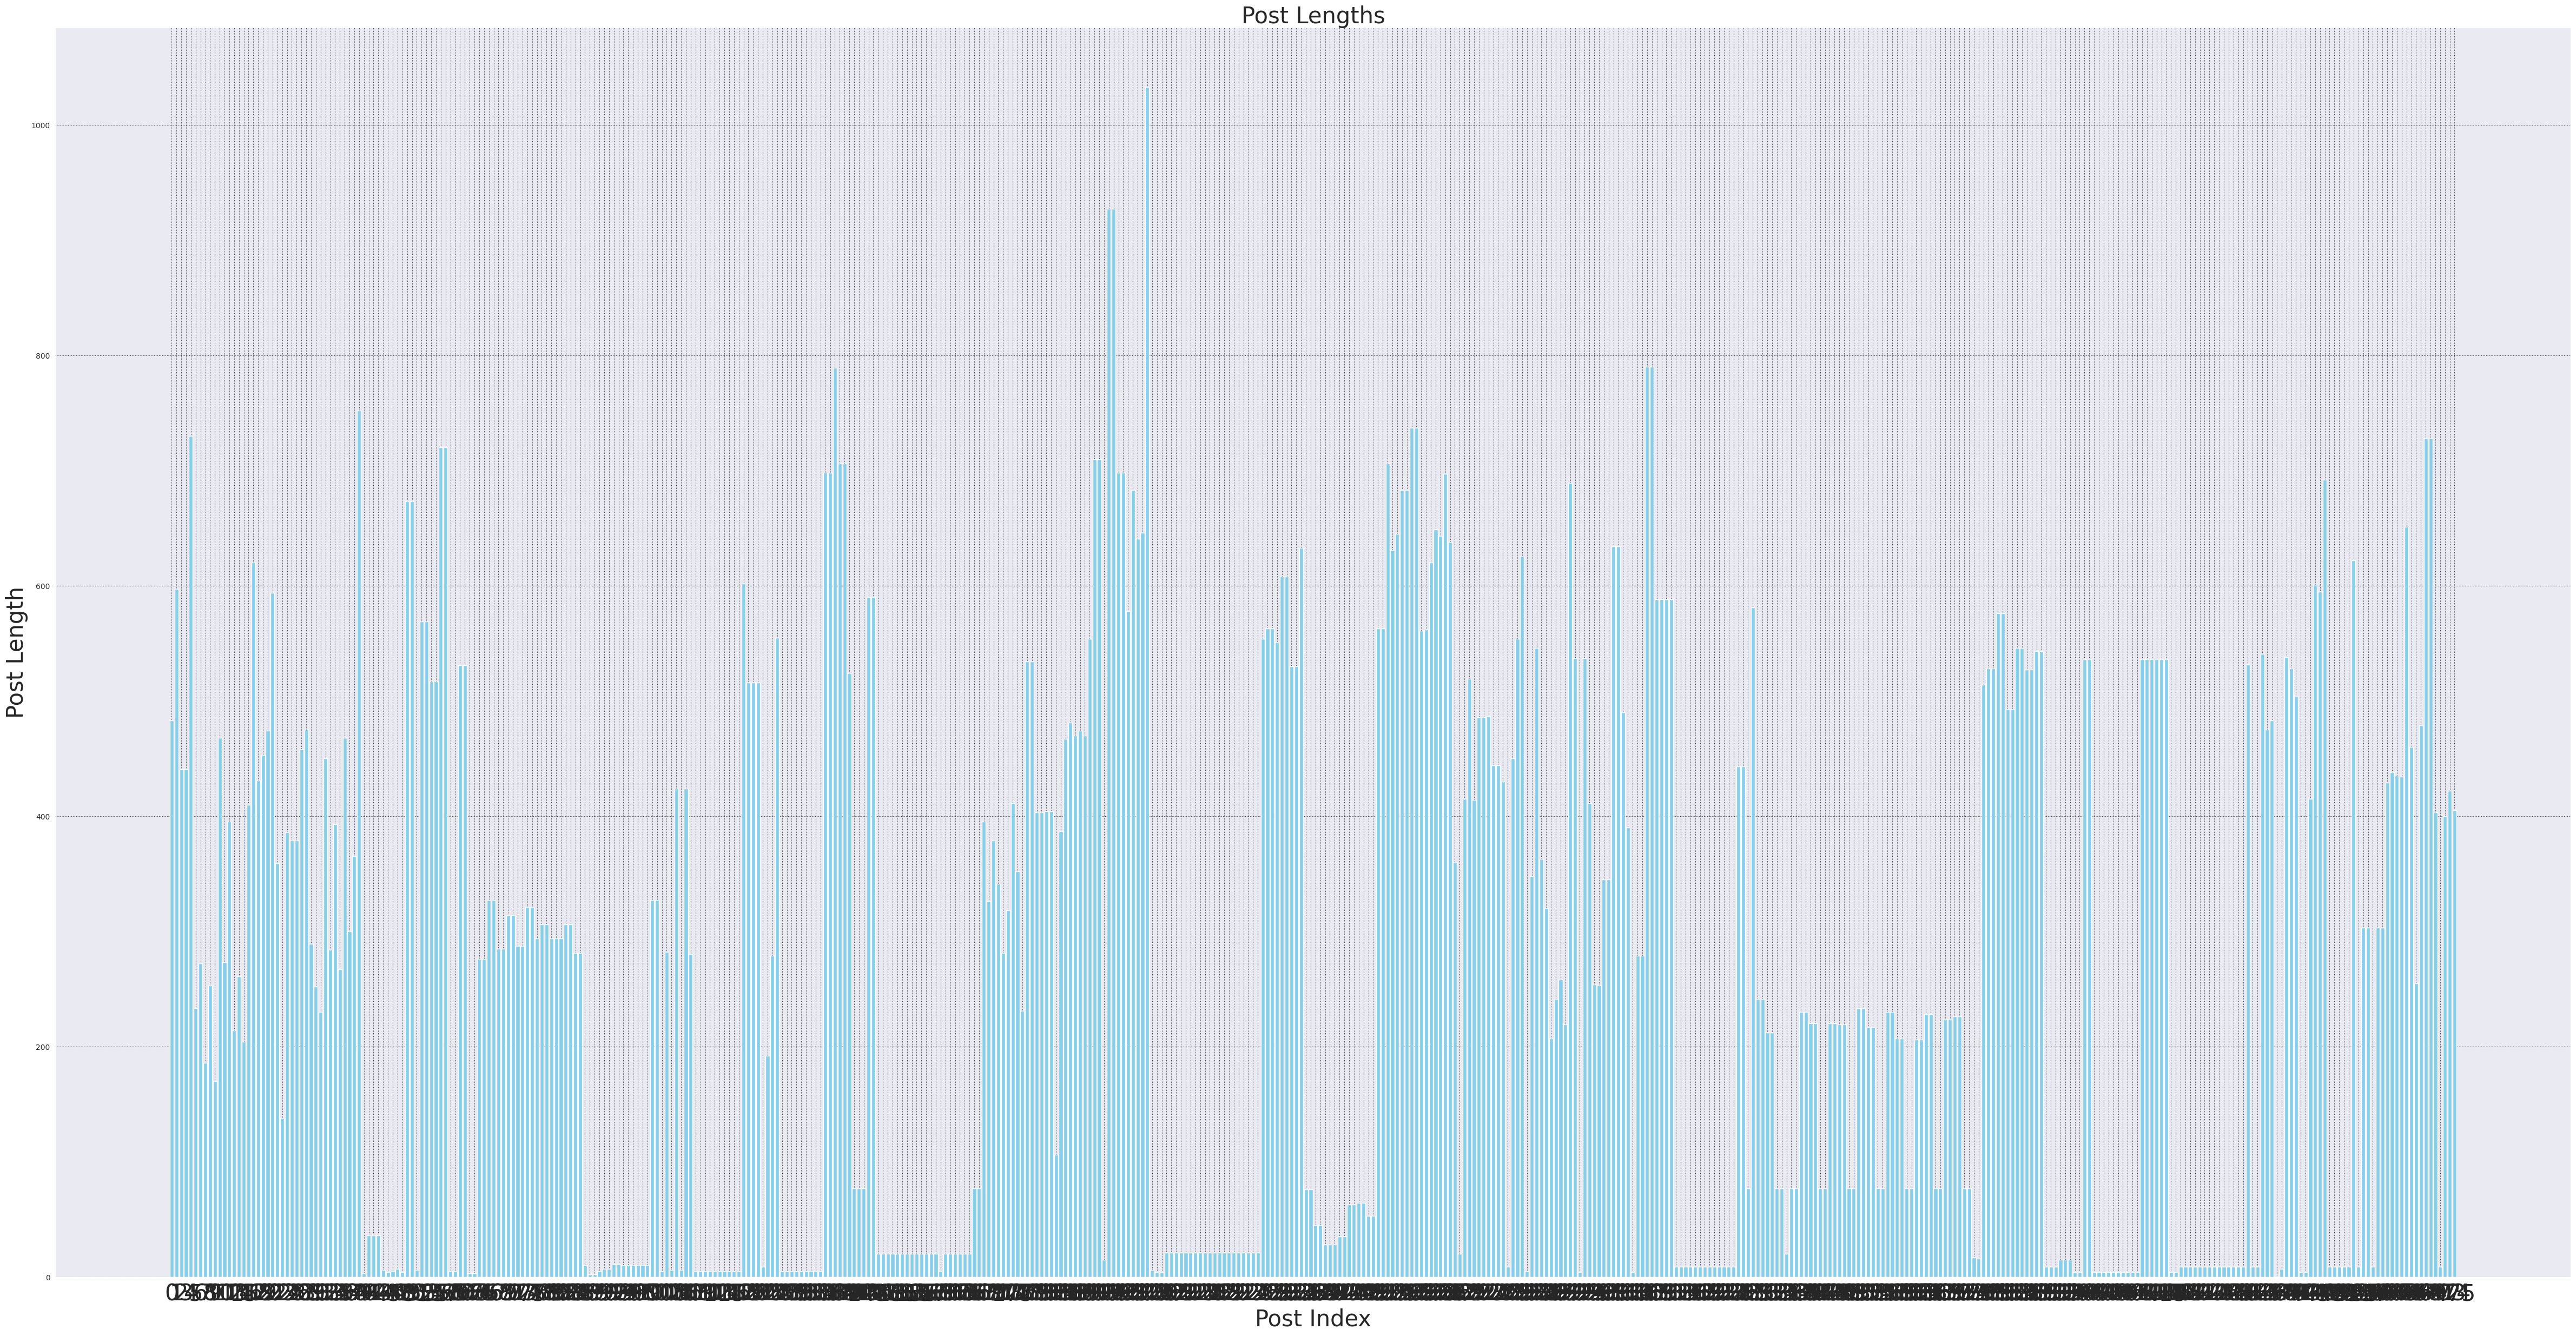

In [ ]:


# Count the length of each post
final_df['post_length'] = final_df['description'].str.len()

# Plotting
plt.figure(figsize=(60, 30))
plt.bar(final_df.index, final_df['post_length'], color='skyblue')
plt.xlabel('Post Index', fontsize=30)
plt.ylabel('Post Length', fontsize=30)
plt.title('Post Lengths', fontsize=30)
plt.xticks(final_df.index, fontsize=30)
plt.show()


In [ ]:
final_df

# Print rows with description length less than 10 characters and drop them
short_desc_rows = final_df[final_df['description'].str.len() < 23]
print("Rows with description length less than 10 characters:")
print(short_desc_rows)

# Drop rows with description length less than 10 characters
final_df = final_df.drop(short_desc_rows.index)

# Display the modified DataFrame
print("\nDataFrame after dropping rows with short description:")
final_df.head(40)

Rows with description length less than 10 characters:
    description                                           category  \
40          79y                                                      
44       iuytrr                                                      
45         gfds                                                      
46        hjfgf                                                      
47      jlk.hj,                                                      
..          ...                                                ...   
452   test copy                        Ideal customer, The tourist   
453   test copy                                     Ideal customer   
455   test copy  Ideal customer, Returning From Holidays, Offsi...   
458   test copy               Ideal customer, Offsite, The tourist   
472   test copy                     Ideal customer, The Vegetarian   

     post_length  
40             3  
44             6  
45             4  
46             5  
47        

,description,category,post_length
0,Celebrare i momenti speciali in luoghi altrett...,"The Newlyweds, The Anniversaries",483
1,🎉✨ Benvenuti nel nostro esclusivo Cenone di Ca...,"Ideal customer, The tourist",597
2,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441
3,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441
4,"🎄 Festeggia il Natale con Gusto, il nostro Men...","The Vegan, The Vegetarian, The Saver",730
5,Se non vuoi affrontare il classico cenone orga...,"I Single, Commuters, The tourist",233
6,Alla ricerca di idee regalo che facciano salta...,"Offsite, The tourist",272
7,"🌹 San Valentino al Ristorante Lo Squalo, dove ...","The couples, The tourist",186
8,Preordina la cena della Vigilia e di San Silve...,"Offsite, Commuters, The tourist",253
9,Vieni a scoprire la magia della vera pizza Nap...,Commuters,170


In [ ]:
final_df['category'] = final_df['category'].astype(str)
final_df.head(10)

,description,category,post_length
0,Celebrare i momenti speciali in luoghi altrett...,"The Newlyweds, The Anniversaries",483
1,🎉✨ Benvenuti nel nostro esclusivo Cenone di Ca...,"Ideal customer, The tourist",597
2,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441
3,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441
4,"🎄 Festeggia il Natale con Gusto, il nostro Men...","The Vegan, The Vegetarian, The Saver",730
5,Se non vuoi affrontare il classico cenone orga...,"I Single, Commuters, The tourist",233
6,Alla ricerca di idee regalo che facciano salta...,"Offsite, The tourist",272
7,"🌹 San Valentino al Ristorante Lo Squalo, dove ...","The couples, The tourist",186
8,Preordina la cena della Vigilia e di San Silve...,"Offsite, Commuters, The tourist",253
9,Vieni a scoprire la magia della vera pizza Nap...,Commuters,170


In [ ]:

# Splitting rows into two separate rows
new_rows = []
for idx, row in final_df.iterrows():
    categories = row['category'].split(', ')
    for category in categories:
        new_row = {
            'description': row['description'],
            'category': category,
            'post_length': row['post_length']
        }
        new_rows.append(new_row)

# Creating a new DataFrame from the split rows
new_df = pd.DataFrame(new_rows)

# Sorting the DataFrame by 'category'
#sorted_df = new_df.sort_values(by='category')


sorted_df = new_df.reset_index(drop=True)

# Remove the first four rows from the sorted DataFrame
sorted_df = sorted_df.iloc[4:]
sorted_df = sorted_df.reset_index(drop=True)
sorted_df.head(10)

,description,category,post_length
0,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441
1,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441
2,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegan,730
3,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegetarian,730
4,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Saver,730
5,Se non vuoi affrontare il classico cenone orga...,I Single,233
6,Se non vuoi affrontare il classico cenone orga...,Commuters,233
7,Se non vuoi affrontare il classico cenone orga...,The tourist,233
8,Alla ricerca di idee regalo che facciano salta...,Offsite,272
9,Alla ricerca di idee regalo che facciano salta...,The tourist,272


### Add Buyer's personas

In [ ]:
# Adding empty columns
sorted_df['Age'] = ''
sorted_df['Type'] = ''
sorted_df['FacebookInterest'] = ''
sorted_df['Behaviours'] = ''
sorted_df['DemographicData'] = ''
sorted_df['Interests'] = ''

# Displaying the first 10 rows
sorted_df.head(10)


,description,category,post_length,Age,Type,FacebookInterest,Behaviours,DemographicData,Interests
0,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441,,,,,,
1,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441,,,,,,
2,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegan,730,,,,,,
3,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegetarian,730,,,,,,
4,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Saver,730,,,,,,
5,Se non vuoi affrontare il classico cenone orga...,I Single,233,,,,,,
6,Se non vuoi affrontare il classico cenone orga...,Commuters,233,,,,,,
7,Se non vuoi affrontare il classico cenone orga...,The tourist,233,,,,,,
8,Alla ricerca di idee regalo che facciano salta...,Offsite,272,,,,,,
9,Alla ricerca di idee regalo che facciano salta...,The tourist,272,,,,,,


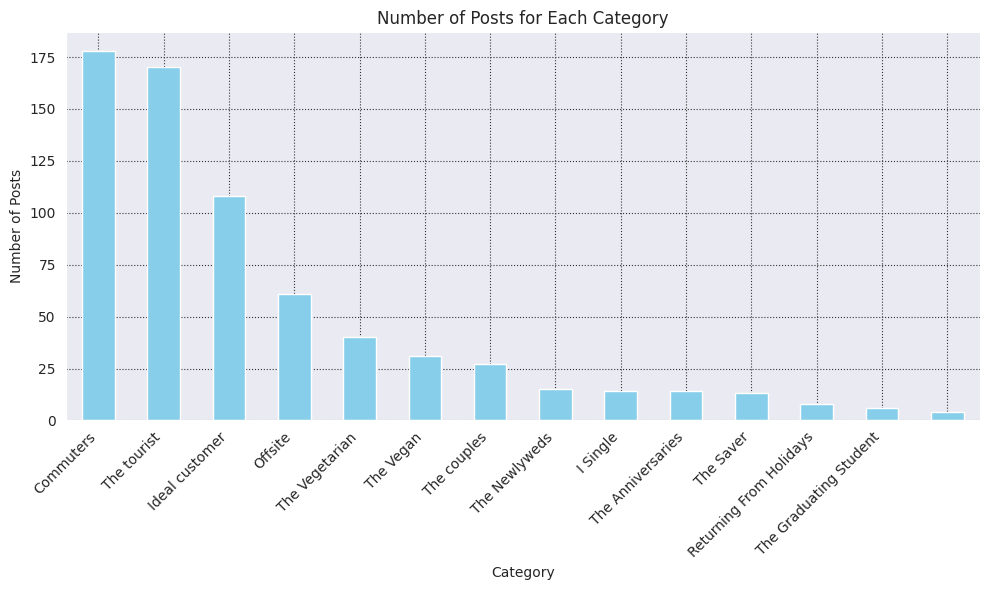

In [ ]:
import matplotlib.pyplot as plt

# Count the number of posts for each category
category_counts = sorted_df['category'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts for Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
## Commuters

# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'Ideal customer', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'Ideal customer', 'Type'] = 'Other'
sorted_df.loc[sorted_df['category'] == 'Ideal customer', 'FacebookInterests'] = 'Restaurants ,Quick casual restaurants ,Subway (ristorante)'



# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'Returning From Holidays', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'Returning From Holidays', 'Behaviours'] = 'Returned from a trip 2 weeks ago or 1 week ago'



# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'Offsite', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'Offsite', 'DemographicData'] = 'Far from family, far from the city of origin'

# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'The Newlyweds', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'The Newlyweds', 'DemographicData'] = 'Newlyweds (1 month, 3 months, 6 months)'


# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'The Anniversaries', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'The Anniversaries', 'DemographicData'] = 'Anniversary within 31-60 days'


# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'The Vegan', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'The Vegan', 'Interests'] = 'Veganism'


# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'The Vegetarian', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'The Vegetarian', 'Interests'] = 'Vegetarianism'

# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'I Single', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'I Single', 'DemographicData'] = 'Divorced, Single, Separated, Widowed'


# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'The Graduating Student', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'The Graduating Student', 'DemographicData'] = 'University years 2020-2023'


# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'The Saver', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'The Saver', 'Interests'] = 'Coupon, Discount'

# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'The couples', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'The couples', 'Interests'] = 'Partner, Officially engaged, in a relationship, open relationship, married, civil union'


# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'Commuters', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'Commuters', 'Behaviors'] = 'Commuters'


# Fill values for rows where category is "The tourist"
sorted_df.loc[sorted_df['category'] == 'The tourist', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'The tourist', 'Behaviors'] = 'tourist'


# Fill values for rows where category is "Commuters"
sorted_df.loc[sorted_df['category'] == 'Commuters', 'Age'] = '18-65'
sorted_df.loc[sorted_df['category'] == 'Commuters', 'Type'] = 'Other'
sorted_df.loc[sorted_df['category'] == 'Commuters', 'FacebookInterest'] = 'Restaurants, Quick casual restaurants, Subway (ristorante)'
# Displaying the DataFrame
sorted_df.head(10)

,description,category,post_length,Age,Type,FacebookInterest,Behaviours,DemographicData,Interests,FacebookInterests,Behaviors
0,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441,18-65,,,,,Vegetarianism,NaN,NaN
1,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441,18-65,,,,,Vegetarianism,NaN,NaN
2,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegan,730,18-65,,,,,Veganism,NaN,NaN
3,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegetarian,730,18-65,,,,,Vegetarianism,NaN,NaN
4,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Saver,730,18-65,,,,,"Coupon, Discount",NaN,NaN
5,Se non vuoi affrontare il classico cenone orga...,I Single,233,18-65,,,,"Divorced, Single, Separated, Widowed",,NaN,NaN
6,Se non vuoi affrontare il classico cenone orga...,Commuters,233,18-65,Other,"Restaurants, Quick casual restaurants, Subway ...",,,,NaN,Commuters
7,Se non vuoi affrontare il classico cenone orga...,The tourist,233,18-65,,,,,,NaN,tourist
8,Alla ricerca di idee regalo che facciano salta...,Offsite,272,18-65,,,,"Far from family, far from the city of origin",,NaN,NaN
9,Alla ricerca di idee regalo che facciano salta...,The tourist,272,18-65,,,,,,NaN,tourist


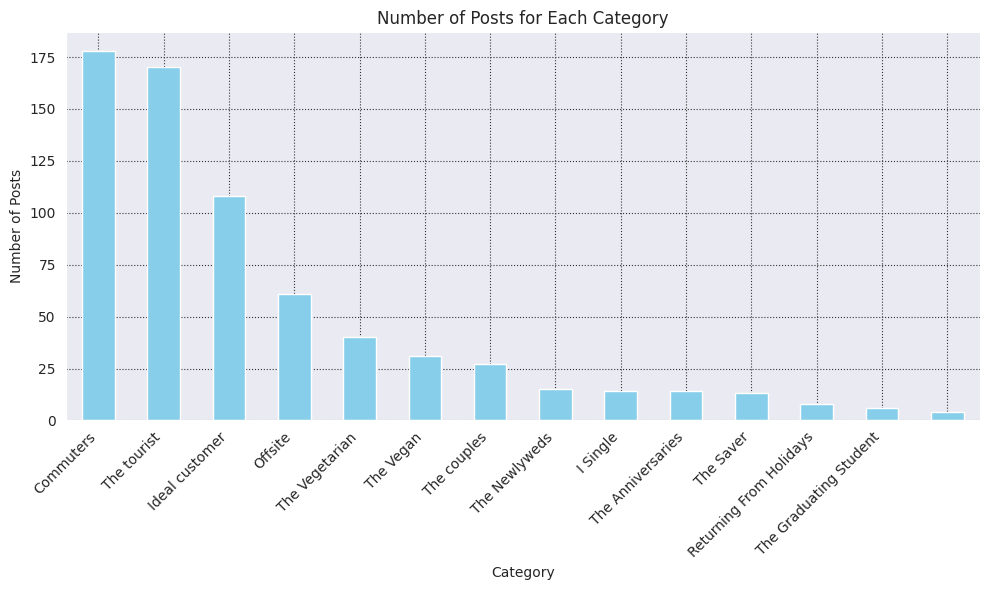

In [ ]:
import matplotlib.pyplot as plt

# Count the number of posts for each category
category_counts = sorted_df['category'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts for Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


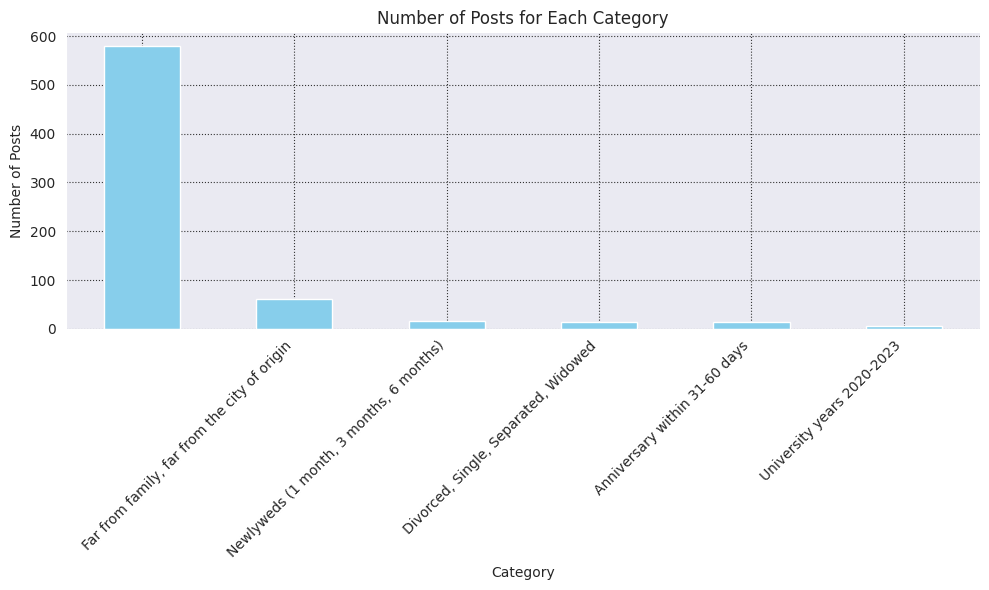

In [ ]:
import matplotlib.pyplot as plt

# Count the number of posts for each category
category_counts = sorted_df['DemographicData'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts for Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


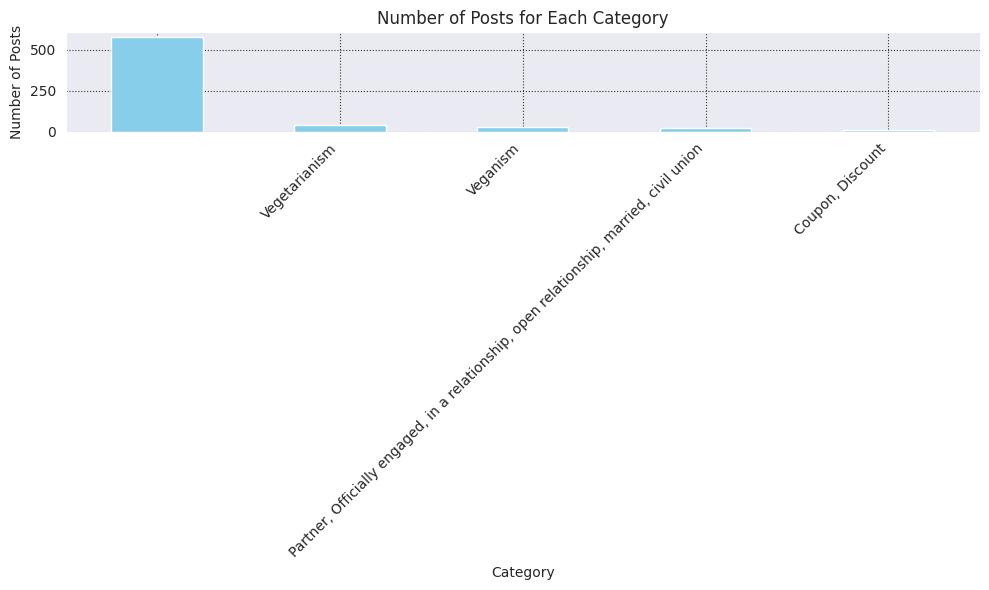

In [ ]:
import matplotlib.pyplot as plt

# Count the number of posts for each category
category_counts = sorted_df['Interests'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts for Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
sorted_df

,description,category,post_length,Age,Type,FacebookInterest,Behaviours,DemographicData,Interests,FacebookInterests,Behaviors
0,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441,18-65,,,,,Vegetarianism,NaN,NaN
1,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441,18-65,,,,,Vegetarianism,NaN,NaN
2,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegan,730,18-65,,,,,Veganism,NaN,NaN
3,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegetarian,730,18-65,,,,,Vegetarianism,NaN,NaN
4,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Saver,730,18-65,,,,,"Coupon, Discount",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
684,🌺Leggi quello che i nostri clienti dicono di n...,Commuters,403,18-65,Other,"Restaurants, Quick casual restaurants, Subway ...",,,,NaN,Commuters
685,🌺Leggi quello che i nostri clienti dicono di n...,The tourist,403,18-65,,,,,,NaN,tourist
686,💙Scopri cosa dicono di noi!💞 \n🌐Dai un'occhiat...,Commuters,400,18-65,Other,"Restaurants, Quick casual restaurants, Subway ...",,,,NaN,Commuters
687,😎Scopri cosa i nostri clienti scrivono di noi....,Commuters,422,18-65,Other,"Restaurants, Quick casual restaurants, Subway ...",,,,NaN,Commuters


In [ ]:
# Function to create the new column
def create_text_column(row):
    if row['category'] == 'Commuters':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "Behaviors": row['Behaviors']}}
    elif row['category'] == 'Ideal customer':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "Type": row['Type'], "FacebookInterests": row['FacebookInterests'].split(', ')}}
    elif row['category'] == 'Returning From Holidays':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "Behaviours": row['Behaviours'].split(', ')}}
    elif row['category'] == 'Offsite':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "DemographicData": row['DemographicData']}}
    elif row['category'] == 'The Newlyweds':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "DemographicData": row['DemographicData']}}
    elif row['category'] == 'The Anniversaries':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "DemographicData": row['DemographicData']}}
    elif row['category'] == 'The Vegan':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "Interests": row['Interests']}}
    elif row['category'] == 'The Vegetarian':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "Interests": row['Interests']}}
    elif row['category'] == 'I Single':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "DemographicData": row['DemographicData']}}
    elif row['category'] == 'The Graduating Student':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "DemographicData": row['DemographicData']}}
    elif row['category'] == 'The Saver':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "Interests": row['Interests']}}
    elif row['category'] == 'The couples':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "Interests": row['Interests']}}
    elif row['category'] == 'The tourist':
        return {"category": row['category'], "Personas": {"Age": row['Age'], "Behaviors": row['Behaviors']}}

# Apply the function to create the new column
sorted_df['Text'] = sorted_df.apply(create_text_column, axis=1)

sorted_df.head(5)

,description,category,post_length,Age,Type,FacebookInterest,Behaviours,DemographicData,Interests,FacebookInterests,Behaviors,Text
0,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441,18-65,,,,,Vegetarianism,NaN,NaN,"{'category': 'The Vegetarian', 'Personas': {'A..."
1,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,The Vegetarian,441,18-65,,,,,Vegetarianism,NaN,NaN,"{'category': 'The Vegetarian', 'Personas': {'A..."
2,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegan,730,18-65,,,,,Veganism,NaN,NaN,"{'category': 'The Vegan', 'Personas': {'Age': ..."
3,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Vegetarian,730,18-65,,,,,Vegetarianism,NaN,NaN,"{'category': 'The Vegetarian', 'Personas': {'A..."
4,"🎄 Festeggia il Natale con Gusto, il nostro Men...",The Saver,730,18-65,,,,,"Coupon, Discount",NaN,NaN,"{'category': 'The Saver', 'Personas': {'Age': ..."


###  Translate Description



### Convert Dataset into LLM input

In [ ]:
INS = """<s>[INST] As an advertising manager, your task is to generate campaign descriptions based on the provided Goal [Ideal customer,Offsite Age,The Newlyweds,The Anniversaries,The Vegan, The Vegetarian,The Single,The Graduating Student,The Saver,The Couples,Commuters,The Tourist] and buyer's persona's .
Craft four descriptions tailored specifically for restaurants based on the provided goal and buyers persona. Incorporate hashtags, emojis, and persuasive call-to-action to drive engagement and conversions..
Your role is to provide three descriptions based on the campaign Name & Interest in a dictionary.
"""

In [ ]:
for i in range(len(sorted_df)):
  goal = sorted_df['Text'][i]
  output = sorted_df['description'][i]
  prompt = f"""{INS} ### Input data:{goal} ### Output:{output}"""
  sorted_df['Text'].iloc[i] = prompt
sorted_df.head()
text_column = sorted_df['Text']
df = pd.DataFrame(text_column)
df.head(10)

,Text
0,"<s>[INST] As an advertising manager, your task..."
1,"<s>[INST] As an advertising manager, your task..."
2,"<s>[INST] As an advertising manager, your task..."
3,"<s>[INST] As an advertising manager, your task..."
4,"<s>[INST] As an advertising manager, your task..."
5,"<s>[INST] As an advertising manager, your task..."
6,"<s>[INST] As an advertising manager, your task..."
7,"<s>[INST] As an advertising manager, your task..."
8,"<s>[INST] As an advertising manager, your task..."
9,"<s>[INST] As an advertising manager, your task..."


In [ ]:
import pandas as pd

# Set the display options to show more rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

# Display the first 20 rows of the DataFrame
df.head(10)

,Text
0,"<s>[INST] As an advertising manager, your task..."
1,"<s>[INST] As an advertising manager, your task..."
2,"<s>[INST] As an advertising manager, your task..."
3,"<s>[INST] As an advertising manager, your task..."
4,"<s>[INST] As an advertising manager, your task..."
5,"<s>[INST] As an advertising manager, your task..."
6,"<s>[INST] As an advertising manager, your task..."
7,"<s>[INST] As an advertising manager, your task..."
8,"<s>[INST] As an advertising manager, your task..."
9,"<s>[INST] As an advertising manager, your task..."


In [ ]:
df.to_csv('advertisingPrompt.csv')

In [4]:
df=pd.read_csv('/content/advertisingPrompt.csv')
df.head(5)

,Unnamed: 0,Text
0,0,"<s>[INST] As an advertising manager, your task..."
1,1,"<s>[INST] As an advertising manager, your task..."
2,2,"<s>[INST] As an advertising manager, your task..."
3,3,"<s>[INST] As an advertising manager, your task..."
4,4,"<s>[INST] As an advertising manager, your task..."
